借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！

In [ ]:

   ## !python -m pip install pandas matplotlib scikit-learn-intelex scikit-learn openpyxl tensorboard seaborn ipykernel ipywidgets tensorflow mypy keras
 #tensorflow[and-cuda]

    

In [ ]:
# 本导入顺序可以看到类型
import tensorflow as tf
import keras
# import tensorflow_datasets as tfds
import datetime
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
from matplotlib import pyplot as plt
from sklearn import preprocessing as p
from sklearn.model_selection import train_test_split

# from tensorflow import keras

from keras import layers
from keras import models
from keras import backend as K

# K =keras.backend

patch_sklearn()
# from attention_utils import get_activations

#更好地兼容 Python 3 的行为和特性，使得代码可以在 Python 2 和 Python 3 下运行得更加一致
# from __future__ import absolute_import,division,print_function,unicode_literals

In [ ]:
import tensorflow as tf
import datetime
print(' ')
print(f'{datetime.datetime.now()} tensorflow版本:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")
print(' ')
print('gpus： ')
print(gpus)
print(' ')
print('gpus')
# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))

In [ ]:
refeshdata = False

categories = ["-", "装", "卸"]


def convert_to_int(data):
    return categories.index(data)


# 确保'label'列是一个分类类型（如果还不是的话）
# if not isinstance(df_selected["label"].dtype, pd.CategoricalDtype):
#     df_selected["label"] = df_selected["label"].astype("category")

if refeshdata or 'dfstate' not in locals() or (hasattr(locals()['dfstate'], 'empty') and locals()['dfstate'].empty):
    dfstate = pd.read_csv("./data/states.txt")
    dfstate["start"] = dfstate.apply(lambda row: row["date"] + " " + row["start_time"], axis=1)
    dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
    dfstate["label"] = dfstate.pop("state").str.strip().apply(convert_to_int)

    # 转为时间类型
    dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
    # dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
    # dfstate['label'] = dfstate.apply(number_to_label,axis=1)
    dfstate.to_csv("./data/states.csv")
    # print(dfstate.head(), dfstate.shape)

dfstate.head()

In [ ]:
dfstate.head()

In [ ]:
# 定义读取数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果
    inputDF.insert(0, "before", False)
    inputDF.insert(0, "after", False)
    inputDF.insert(0, "label", 0)
    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():

        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]
        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass

    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF


def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"]))


# 读取数据
if (refeshdata or "odf17" not in locals() or (hasattr(locals()["odf17"], "empty") and locals()["odf17"].empty)):
    # 如果df未定义或为空DataFrame
    odf17 = read_data("./data/data_17.xlsx")
    odf21 = read_data("./data/data_21.xlsx")
    odf22 = read_data("./data/data_22.xlsx")
    odf23 = read_data("./data/data_23.xlsx")

In [ ]:

output_folder="./model_output"

#用来保存模型以及我们需要的所有东西
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
save_format="hdf5" #或saved_model
if save_format=="hdf5":
    save_path_models=os.path.join(output_folder,"hdf5_models")
    if not os.path.exists(save_path_models):
        os.makedirs(save_path_models)
    model_save_path=os.path.join(save_path_models,"ckpt_epoch{epoch:02d}_val_acc{val_accuracy:.2f}.hdf5")
    
elif save_format=="saved_model":
    save_path_models=os.path.join(output_folder,"saved_models")
    if not os.path.exists(save_path_models):
        os.makedirs(save_path_models)
    model_save_path=os.path.join(save_path_models,"ckpt_epoch{epoch:02d}_val_acc{val_accuracy:.2f}.ckpt")
#用来保存日志
log_dir= os.path.join(output_folder,'logs_{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

组合数据集

In [ ]:
numeric_col_names = ['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x', 'su_y', 'su_z']
# delete some
#  "轨迹时间",'原始重量_diff', '稳定重量_diff', '轴重_diff','su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff','估计重量',    'su_x_diff','su_y_diff', 'su_z_diff',  ,
# ['原始重量', '稳定重量', '轴重', 'su_ad',
#                 'wpu_x', 'wpu_y', 'wpu_z',
#                 'su_x', 'su_y', 'su_z',
#                 '原始重量_diff', '稳定重量_diff', '轴重_diff',
#                 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
#                 'su_x_diff', 'su_y_diff', 'su_z_diff',
#                 '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶']
label_col_names = ["label"]
time_col_names = ["时间"]
feature_col_names = numeric_col_names  # 暂时去掉 时间
feature_col_num = len(feature_col_names)

class_num = len(categories)
# print(class_num)
time_steps = 3
# batch_size = 20
batch_size = 5
epochs = 500
lr_decay_epochs=1

all_col_names = numeric_col_names + label_col_names + time_col_names
df17, df21, df22, df23 = odf17[all_col_names], odf21[all_col_names], odf22[all_col_names], odf23[all_col_names]
_origindata = pd.concat([df17, df21, df22], axis=0, ignore_index=True)

print(_origindata.columns)

# _origindata.head()

筛选数据，

In [ ]:
def expandRows(idx_list_list, windowsize=20) -> np.ndarray:
    my_array = np.arange(-windowsize, windowsize + 1)
    new_array = idx_list_list.copy()
    for item in my_array:
        new_array += [element + item for element in indices_list]
    ret = np.sort(list(dict.fromkeys(new_array)))

    return ret


indices_list = _origindata.index[_origindata['label'] > 0].tolist(
)  # + _origindata.index[_origindata['label'] == '卸'].tolist()
indices_list = expandRows(indices_list)

# 或者使用.iloc基于位置索引（如果是整数索引）
# df_selected = _origindata.iloc[indices_list]

df_selected =_origindata

df_selected.head()

In [ ]:
# df_selected[feature_col_names + label_col_names].plot(legend=True, subplots=True, figsize=(30, 30), xlabel="steps")
# ax = plt.gca()
# # ax.set_xlim(left=0, right=7600)
# # 或者直接指定字体文件路径
# # plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 系统自带的黑体
# # plt.rcParams['font.serif'] = ['DejaVu Sans']  # 系统自带的宋体
# # plt.rcParams['font.family'] = ['DejaVu Sans']
# plt.show()


In [ ]:
# 归一化函数
def normalize(inpudf: pd.DataFrame, numeric_col_names: list[str]) -> np.ndarray:
    # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
    # 创建标准化器对象
    scaler = p.MinMaxScaler()
    return scaler.fit_transform(inpudf)
    # for col in numeric_col_names :
    #     result[col]=scaler.fit_transform(np.asarray(inpudf[col] ))


# def normalizeY(y: pd.DataFrame):
#     """对df中的数值列进行反标准化处理"""
#     # 定义一个字典，将标签映射到整数值
#     custom_label_dict = {    '-': 0, '卸': 1, '装': 2, }
#     le = OneHotEncoder(categories='auto', sparse=False)
#     print('mapping ---->',custom_label_dict)
#     # 现在我们可以将ydata转换为数值
#     ydata_numeric = y.apply(lambda x: custom_label_dict[x['label']],axis=1)
#     return ydata_numeric
def normalizeY(y: pd.DataFrame):
    """对df中的数值列进行反标准化处理"""
    # 定义一个字典，将标签映射到整数值
    ydata = np.asarray(y[label_col_names])
    le = p.OneHotEncoder()
    le.fit(ydata)

    return le.transform(ydata), le


In [ ]:
# class weights


from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series:np.ndarray, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    # class_count = [0] * n_classes
    # for classes in class_series:
    #     for index in range(n_classes):
    #         if classes[index] != 0:
    #             class_count[index] += 1
    
    class_count = np.array(class_series).sum(axis=0)
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [ ]:
# 准备数据
def windowed_dataset(dataset: tf.data.Dataset, window_size=5, shift=1, stride=1):
    windows = dataset.window(window_size, shift=shift, stride=stride, drop_remainder=True)

    def sub_to_batch(t1, t2=None):
        t1_batches = t1.batch(window_size, drop_remainder=True)

        if t2 is not None:
            t2_batches = t2.batch(window_size, drop_remainder=True)
            return tf.data.Dataset.zip(t1_batches, t2_batches)
        else:
            return t1_batches

    windows = windows.flat_map(sub_to_batch)
    return windows


def one_hot_encoding(label):
    return tf.squeeze(tf.one_hot(label, depth=class_num))


y = tf.data.Dataset.from_tensor_slices(df_selected[label_col_names]).map(one_hot_encoding)

test_weight = generate_class_weights(list(y), multi_class=True, one_hot_encoded=True)


# 定义用于归一化/标准化的函数
def normalize_feature1(value):
    mean = tf.reduce_mean(value)
    std = tf.math.reduce_std(value)
    return (value - mean) / std


def normalize_feature2(value):
    min_val = tf.reduce_min(value)
    max_val = tf.reduce_max(value)
    return (value - min_val) / (max_val - min_val)


# 使用map函数对不同特征列进行相应的归一化
# normalized_dataset = dataset.map(
#     lambda feats: {
#         'feature1': normalize_feature1(feats['feature1']),
#         'feature2': normalize_feature2(feats['feature2']),
#     })
# for col in feature_col_names:
#     df_selected[col] =scaler.fit_transform(df_selected[col])

scaler = p.StandardScaler()
normalized = scaler.fit_transform(df_selected[feature_col_names])

x = tf.data.Dataset.from_tensor_slices(normalized)
featureTarget = windowed_dataset(x, time_steps)

target = tf.data.Dataset.zip(featureTarget, y)

total_examples = len(x)  # 获取数据集总样本数
train_ratio = 0.6  # 训练集占比
num_train_examples = int(total_examples * train_ratio)
num_val_examples = total_examples - num_train_examples
train_dataset = target.take(num_train_examples)
val_dataset = target.skip(num_train_examples).take(num_val_examples)

trainWindow = train_dataset.batch(batch_size=batch_size)
valWindow = val_dataset.batch(batch_size=batch_size)

for x, y in trainWindow.take(1):
    print('x=======================')
    print(x.numpy())
    print('y---------------------')
    print(y.numpy())

# Embedding的一些关键点

Embedding是一种在深度学习中常用的技术，它将输入数据（如单词、图像、句子等）映射到低维度的向量空间中。这种映射使得原始数据可以被模型更好地处理和理解。在自然语言处理（NLP）中，嵌入通常用于将单词或字符转换为固定大小的向量，这些向量可以捕捉词汇的语义和上下文信息

1.  **维度 reduction**: 嵌入将高维数据（如词汇表中的单词）映射到低维空间，使得模型可以更容易地处理。
    
2.  **固定大小**: 嵌入向量通常是固定大小的，这使得它们可以被矩阵操作，便于模型处理。
    
3.  **非线性**: 嵌入通常是通过对输入数据进行非线性变换来生成的，这有助于模型捕捉复杂的关系。
    
4.  **预训练和微调**: 在NLP中，单词嵌入通常预先训练然后在特定任务上微调。预训练可以捕获通用语义信息，而微调可以捕捉任务特定的信息。
    
5.  **神经网络**: 嵌入经常与神经网络一起使用，特别是卷积神经网络（CNN）和循环神经网络（RNN），以处理复杂的输入数据。
    
6.  **应用**: 除了NLP，嵌入技术还广泛应用于计算机视觉（如图像嵌入）、音频处理和其他领域。


In [ ]:
## 模型创建
from os import name

SINGLE_ATTENTION_VECTOR = False


def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    # a = Permute((2, 1))(inputs)
    # a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = layers.Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = layers.Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = layers.RepeatVector(input_dim)(a)
    a_probs = layers.Permute((1, 2), name='attention_vec')(a)  # 维数转置

    output_attention_mul = layers.concatenate([inputs, a_probs], axis=-1)  # 把两个矩阵拼接
    return output_attention_mul


regularizer = keras.regularizers.l2(0.01)


def attention_model(time_steps: int, input_dims: int, lstm_units: int, output_dim: int) -> models.Model:
    inputs = layers.Input(shape=(time_steps, input_dims), name='input')
    x = layers.Dense(units=1024, name='dense1', activation='relu', kernel_initializer='HeUniform')(inputs)
    x = layers.Conv1D(filters=512, kernel_size=1, activation='relu', kernel_initializer='HeUniform')(inputs)  # , padding = 'same'
    x = layers.MaxPool1D(pool_size=2)(x)
    # x = layers.Dropout(0.3)(x)
    for i in range(10):
        x = layers.Dense(units=1024, activation='relu', kernel_regularizer=regularizer, kernel_initializer='HeUniform', name='Dense_a_' + str(i + 2))(x)
    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    # 对于GPU可以使用CuDNNLSTM
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, name='lstm1'))(x)
    x = layers.Dropout(0.3, name='dorpot1')(x)
    x = attention_3d_block(x)
    # x = layers.MultiHeadAttention(num_heads=3,
    #                               key_dim=64,
    #                               value_dim=64,
    #                               name='attention')(x)
    for i in range(2):
        x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, name='lstm' + str(i + 2)))(x)
        x = layers.Dropout(0.3, name='dorpot' + str(i + 2))(x)
    for i in range(10):
        x = layers.Dense(units=1024, activation='relu', kernel_regularizer=regularizer, kernel_initializer='HeUniform', name='Dense_b_' + str(i + 2))(x)
    x = layers.Flatten()(x)
    # attention_mul = layers.Embedding(input_dims, output_dim)(attention_mul)
    output = layers.Dense(output_dim, activation='softmax', name='output_')(x)
    model = keras.Model(inputs=[inputs], outputs=output)
    return model

In [ ]:
# 编译模型 Old
# drop = 0.2

# # 调整学习率
# optimizer = keras.optimizers.Adam(learning_rate=0.2)  # 学习率设置为0.001

# # class_num=1
# lstm_units = 64

# model = attention_model(time_steps, feature_col_num, lstm_units, class_num)

# model.compile(
#     optimizer=optimizer,
#     loss=keras.losses.CategoricalCrossentropy(),
#     metrics=['accuracy'],
#     #   steps_per_execution=5
# )

# model.summary()

In [ ]:
# 编译模型
# class_num=1
lstm_units = 64
model = attention_model(time_steps, feature_col_num, lstm_units, class_num)

#学习率变化设置，使用指数衰减
train_steps_per_epoch = int(total_examples // batch_size)
initial_learning_rate = 0.01
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
#                                                              decay_steps=1*train_steps_per_epoch,
#                                                             decay_rate=0.96,
#                                                             staircase=True)#initial_learning_rate*0.96**(step/decay_steps)
#优化算法
optimizer = keras.optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.95)
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
#损失函数
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
#评价指标
# metrics=[keras.metrics.SparseCategoricalAccuracy(),loss]
metrics = ['accuracy']  #, 'categorical_crossentropy'

# 标签平滑损失函数
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
#上式第二个参数会返回交叉熵的结果，用loss减去该值就会得到正则化的值（于model.losses和相等），这两种定义方式都可以，下边的会显示名称短一些
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()


In [ ]:
#模型保存格式默认是saved_model,可以自己定义更改原有类来保存hdf5
ckpt = keras.callbacks.ModelCheckpoint(model_save_path.replace('.hdf5', '.keras'), monitor='val_accuracy', verbose=1, save_best_only=False, save_weights_only=False, save_freq='epoch', mode='auto')
#当模型训练不符合我们要求时停止训练，连续5个epoch验证集精度没有提高0.001%停
earlystop = keras.callbacks.EarlyStopping(
    monitor='accuracy',  # 监控的量，val_loss, val_acc, loss, acc
    min_delta=0,  # 监控量的变化量，当大于该值时，认为模型在性能上没有提升
    patience=10,  # 当patience个epoch内，监控量没有提升时，停止训练
    verbose=1,  # 0,1,2,3,4,5,6,7,8,9,10,11,12,1
    mode='accuracy',  # auto, min, max    monitor='val_accuracy',
    baseline=None,  # 基准线，当monitor达到baseline时，patience计数器清零
    restore_best_weights=True,  # 是否恢复训练时验证集上表现最好的权重
)
#3、自定义学习率按需衰减，并把整个学习率变化过程保存
class LearningRateExponentialDecay:

    def __init__(self, initial_learning_rate, decay_epochs, decay_rate):
        self.initial_learning_rate = initial_learning_rate
        self.decay_epochs = decay_epochs
        self.decay_rate = decay_rate

    def __call__(self, epoch):
        dtype = type(self.initial_learning_rate)
        decay_epochs = np.array(self.decay_epochs).astype(dtype)
        decay_rate = np.array(self.decay_rate).astype(dtype)
        epoch = np.array(epoch).astype(dtype)
        p = epoch / decay_epochs
        lr = self.initial_learning_rate * np.power(decay_rate, p)
        return lr

lr_schedule = LearningRateExponentialDecay(initial_learning_rate, lr_decay_epochs, 0.96)
lr = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
#使用tensorboard
#定义当loss出现nan或inf时停止训练的callback
terminate = keras.callbacks.TerminateOnNaN()

#模型损失长时间不除时大程度降低学习率
# 这个策略通常不于学习率衰减schedule同时使用，或者使用时要合理
#降低学习率（要比学习率自动周期变化有更大变化和更长时间监控）
# 模型损失长时间不除时大程度降低学习率
# 这个策略通常不于学习率衰减schedule同时使用，或者使用时要合理
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1,
                                              patience=3,
                                              verbose=1,
                                              min_delta=0.0001,
                                              min_lr=0)

#保存训练过程中大数标量指标，与tensorboard同一个文件
csv_logger = keras.callbacks.CSVLogger(os.path.join(log_dir, 'logs.log'), separator=',')

#还要加入tensorboard的使用,这种方法记录的内容有限
#各个参数的作用请参看文档，需要正确使用
tensorboard = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  #对参数和激活做直方图，一定要有测试集
    write_graph=True,  #模型结构图
    write_images=True,  #把模型参数做为图片形式存到
    update_freq='epoch',  #epoch,batch,整数，太频的话会减慢速度
    profile_batch=2,  #记录模型性能
    embeddings_freq=1,
    embeddings_metadata=None  #这个还不太清楚如何使用
)


In [44]:
callbacks = [ckpt, earlystop, lr, tensorboard, terminate, reduce_lr, csv_logger]

history = model.fit(
    trainWindow,
    epochs=epochs,
    verbose='auto',
    # batch_size=batch_size,
    validation_data=valWindow,
    # validation_split=0.2,
    # shuffle=False,
    callbacks=callbacks,
    class_weight=test_weight,
    # workers=10
)

   8328/Unknown - 249s 29ms/step - loss: 1.3855 - accuracy: 0.5979
Epoch 1: saving model to ./model_output/hdf5_models/ckpt_epoch01_val_acc0.97.keras
8329/8329 [==============================] - 350s 41ms/step - loss: 1.3854 - accuracy: 0.5979 - val_loss: 0.5230 - val_accuracy: 0.9696 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.0096.
Epoch 2/500
8329/8329 [==============================] - ETA: 0s - loss: 1.1259 - accuracy: 0.5658
Epoch 2: saving model to ./model_output/hdf5_models/ckpt_epoch02_val_acc0.97.keras
8329/8329 [==============================] - 340s 41ms/step - loss: 1.1259 - accuracy: 0.5658 - val_loss: 0.5369 - val_accuracy: 0.9696 - lr: 0.0096

Epoch 3: LearningRateScheduler setting learning rate to 0.009216.
Epoch 3/500
8329/8329 [==============================] - ETA: 0s - loss: 1.1256 - accuracy: 0.5655
Epoch 3: saving model to ./model_output/hdf5_models/ckpt_epoch03_val_acc0.97.keras
8329/8329 [==============================] - 331s 40ms/s

In [45]:
# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1
# 网页中可以查看模型训练过程

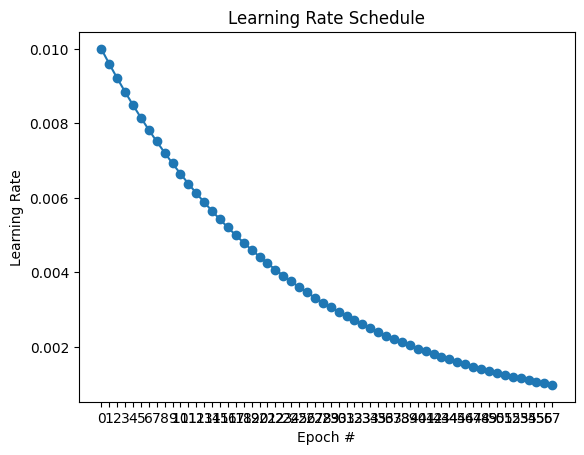

In [46]:
H = history


#画学习率变化曲线并保存到log中
def plot(lrs, title="Learning Rate Schedule"):
    #计算学习率随epoch的变化值
    epochs = np.arange(len(lrs))
    plt.figure()
    plt.plot(epochs, lrs)
    plt.xticks(epochs)
    plt.scatter(epochs, lrs)
    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Learning Rate")


plot(H.history['lr'])
plt.savefig(os.path.join(log_dir, 'learning_rate.png'))

In [47]:
# 保存模型结构及配置参数
model_json = model.to_json()
with open(os.path.join(log_dir,'model_json.json'),'w') as json_file:
    json_file.write(model_json)


In [48]:
#对模型在测试集上进行评估
metrics = model.evaluate(valWindow, verbose=1)
print("val_loss:", metrics[0], "val_accuracy:", metrics[1])


5553/5553 [==============================] - 102s 18ms/step - loss: 0.6907 - accuracy: 0.9696
val_loss: 0.690656840801239 val_accuracy: 0.9695616364479065


In [49]:
predictions=model.predict(valWindow,verbose=1)

5553/5553 [==============================] - 85s 15ms/step


In [50]:
# # data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# # ax = plt.gca()
# # ax.set_xlim(left=0, right=19000)

# # # 或者直接指定字体文件路径
# # plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
# # plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
# # plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN']

# # plt.show()
# times = df22[time_col_names].index.to_numpy()
# display(times)
# plt.plot(times, y, label="Actual", marker="o")
# plt.plot(times, predictions, label="Predicted", linestyle="--", marker="x")

# ax = plt.gca()
# ax.set_xlim(left=12000, right=18000)
# # 添加标题和标签
# plt.title("Actual vs. Predicted Values")
# plt.xlabel("Sample Index")
# plt.ylabel("Value")

# # 添加图例
# plt.legend()

# # 显示图形
# plt.show()

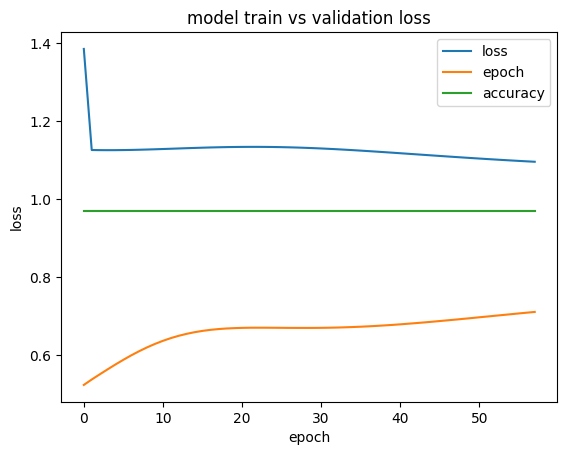

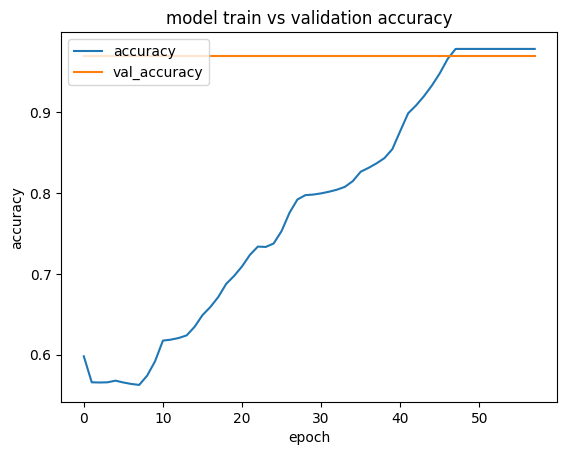

In [51]:
# display(history.history)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "epoch", "accuracy"], loc="upper right")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [52]:
display(df22.columns)

Index(['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x',
       'su_y', 'su_z', 'label', '时间'],
      dtype='object')

In [53]:
# data22, scaler22 = normalize(df22, numeric_col_names)
# X22 = data22[feature_col_names]
# y_test22 =normalizeY( df22[label_col_names])
# x_train22  = np.asarray(X22) .reshape(-1, feature_col_num)
# predY22 = model.predict(x_train22, batch_size=batch_size)


# data23, scaler23 = normalize(df23, numeric_col_names)
# X23 = data23[feature_col_names]
# y_test23 =normalizeY( df23[label_col_names])
# x_train23  = np.asarray(X23) .reshape(-1, feature_col_num)
# predY23 = model.predict(x_train23, batch_size=batch_size)






# display(predY22,predY23)

In [54]:
# fig_acc = plt.figure(figsize=(9, 9))
# plt.plot(predY23[0:27000])
# plt.plot(y_test23[0:27000])
# plt.title("real vs pred")
# plt.ylabel("value")
# plt.xlabel("epoch")
# plt.xlim((19000, 23000))
# plt.legend(["pred", "real"], loc="upper left")
# plt.show()